In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/home/marco/phd/devel/exotic/exotic/')

import os
import xarray as xr
import math
import numpy as np
import matplotlib.pyplot as plt

from lab import analysis
from lab.simulation import forcings

REF_RESP_PATH = [
    '/home/marco/phd/data/response/lorenz96/rk4/SF_8.0_1.0_0/',
    '/home/marco/phd/data/response/lorenz96/rk4/SF_8.0_-1.0_0/'            
]

SAVE_FIG = False

## Multiple Plots

In [2]:
force_linear_coefficient = 0.01
deactivation_time = 100
forcing = 'LF_8.0_{}_0_{}'.format(force_linear_coefficient, deactivation_time)

observable = 'energy'

QUANTILES_PATH = f'/home/marco/phd/data/obs/lorenz96/rk4/CF_8.0/quantiles/obs_lorenz96_rk4_CF_8.0_quantiles_{observable}.nc'

### Bins

In [3]:
obs_all = [f"{observable}_bin_{format(np.round(quant, 1), '.2f')}q_{format(np.round(quant + 0.1, 1), '.2f')}q" for quant in np.arange(0, 0.9, 0.1)]
obs_all.append(f'{observable}_exceed_0.90q')

Compute **susceptibilities**

In [4]:
chi_semidiff = {}
chi_normal = {}
for obs in obs_all:
    response_p1 = xr.open_dataarray(os.path.join(
        REF_RESP_PATH[0],
        observable,
        f'response_lorenz96_rk4_{obs}_SF_8.0_1.0_0.nc'
    ))
    response_m1 = xr.open_dataarray(os.path.join(
        REF_RESP_PATH[1],
        observable,
        f'response_lorenz96_rk4_{obs}_SF_8.0_-1.0_0.nc'
    ))
    response_semidiff = (response_p1 - response_m1)/2
    chi_semidiff[obs] = analysis.compute_susceptibility(response_semidiff.values.squeeze())
    chi_normal[obs] = analysis.compute_susceptibility(response_p1.values.squeeze())

Compute **predicted responses**

In [5]:
resp_real = {}
resp_pred_semidiff = {}
resp_pred_normal = {}
for obs in obs_all:
    resp_real[obs] = xr.open_dataarray(
        f'/home/marco/phd/data/response/lorenz96/rk4/{forcing}/{observable}/response_lorenz96_rk4_{obs}_{forcing}.nc'
    )
    resp_pred_semidiff[obs] = analysis.compute_response(chi_semidiff[obs], forcings.LinearForcing(
        linear_coefficient=force_linear_coefficient,
        deactivation_time=deactivation_time
    ))
    resp_pred_normal[obs] = analysis.compute_response(chi_normal[obs], forcings.LinearForcing(
        linear_coefficient=force_linear_coefficient,
        deactivation_time = deactivation_time
    ))

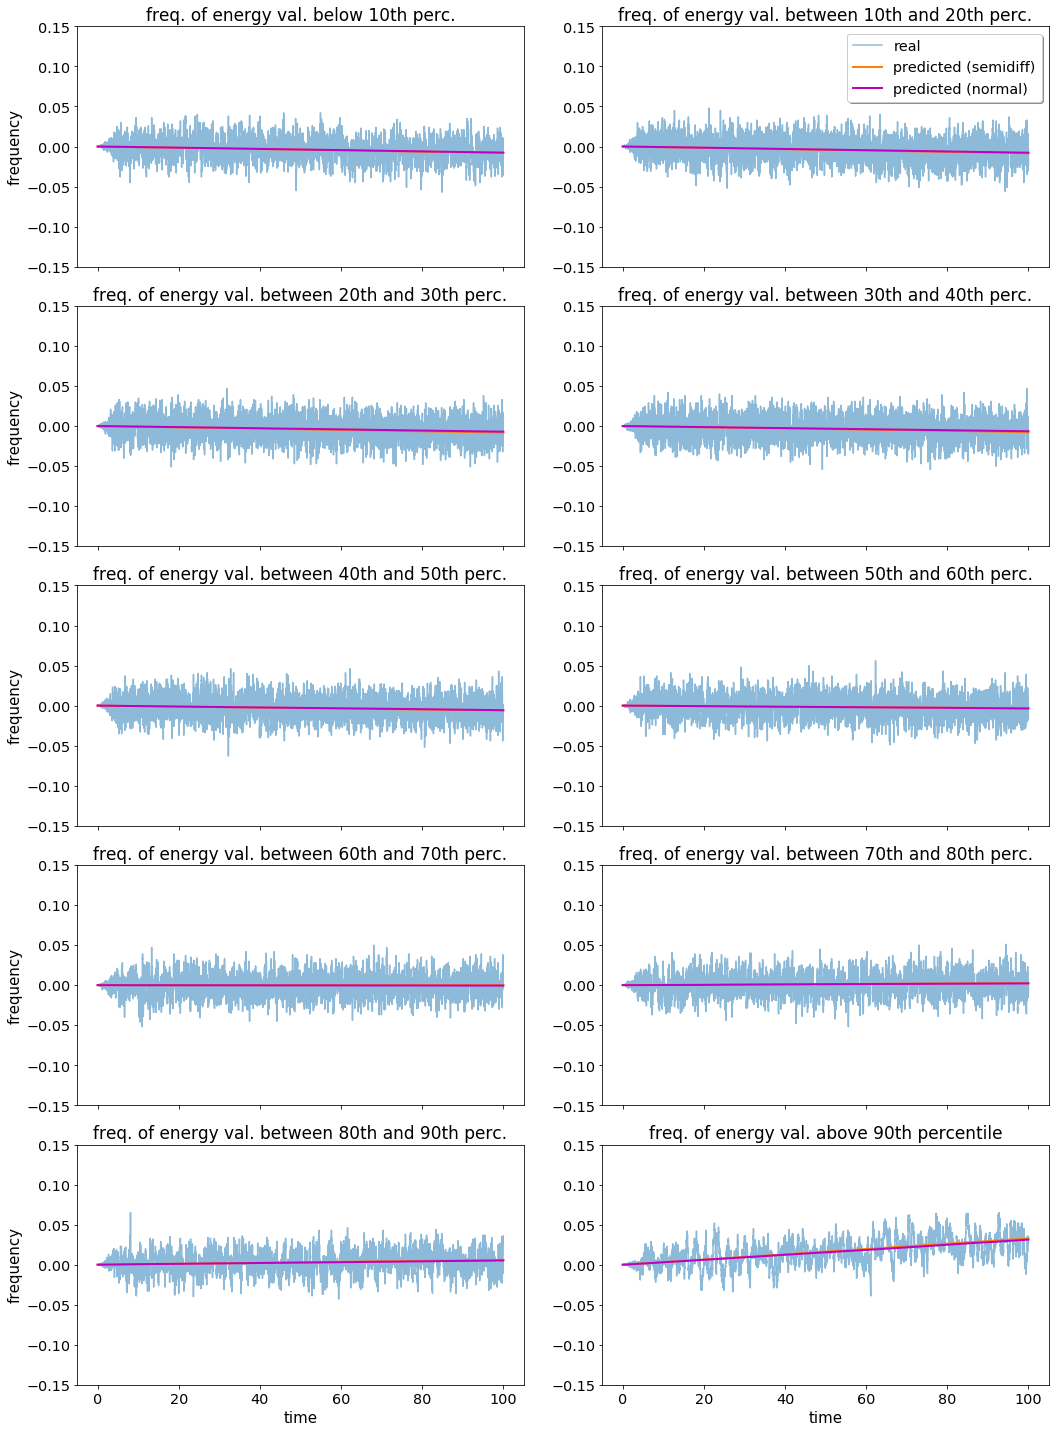

In [6]:
fig, ax = plt.subplots(5, 2, sharex='all', sharey=False, figsize=(15, 20))

titles = [
    f'freq. of {observable} val. below 10th perc.',
    f'freq. of {observable} val. between 10th and 20th perc.',
    f'freq. of {observable} val. between 20th and 30th perc.',
    f'freq. of {observable} val. between 30th and 40th perc.',
    f'freq. of {observable} val. between 40th and 50th perc.',
    f'freq. of {observable} val. between 50th and 60th perc.',
    f'freq. of {observable} val. between 60th and 70th perc.',
    f'freq. of {observable} val. between 70th and 80th perc.',
    f'freq. of {observable} val. between 80th and 90th perc.',
    f'freq. of {observable} val. above 90th percentile',
]

k = 0
for i in range(5):
    for j in range(2):
        l1, = ax[i, j].plot(np.arange(0, 100, 0.01), resp_real[obs_all[k]].values, alpha=0.5)
        l2, = ax[i, j].plot(np.arange(0, 100, 0.01), resp_pred_semidiff[obs_all[k]][0:10000], linewidth=2)
        l3, = ax[i, j].plot(np.arange(0, 100, 0.01), resp_pred_normal[obs_all[k]][0:10000], linewidth=2, color='m')
        ax[i, j].set_title(titles[k], size=17)
        ax[i, j].set_ylim([-0.15, 0.15])
        ax[i, j].tick_params(labelsize='x-large')
        std_real = resp_real[obs_all[k]].std().values
        avg_real = resp_real[obs_all[k]].mean().values
        sig_digit_real = -math.floor(math.log10(std_real))
        std_pred_normal = resp_pred_normal[obs_all[k]][0:10000].std()
        avg_pred_normal = resp_pred_normal[obs_all[k]][0:10000].mean()
        sig_digit_pred_normal = -math.floor(math.log10(std_pred_normal))
        std_pred_semidiff = resp_pred_semidiff[obs_all[k]][0:10000].std()
        avg_pred_semidiff = resp_pred_semidiff[obs_all[k]][0:10000].mean()
        sig_digit_pred_semidiff = -math.floor(math.log10(std_pred_semidiff))

        if k==1:
            ax[i, j].legend((l1, l2, l3), ('real', 'predicted (semidiff)', 'predicted (normal)'), loc='upper right', shadow=True, fontsize='x-large')
        if not j%2:
            ax[i, j].set_ylabel('frequency', size=15)
        if i==4:
            ax[i, j].set_xlabel('time', size=15)
            
        k += 1
        
plt.tight_layout()

if SAVE_FIG:
    plt.savefig('/home/cucchi/phd/devel/phd/logbook/fig/pred_bin_L_{}_{}.png'.format(
        str(force_linear_coefficient).replace('.',''),
        str(deactivation_time)
    ))

### Below

In [7]:
obs_all = [f"{observable}_below_{format(np.round(quant + 0.1, 1), '.2f')}q" for quant in np.arange(0, 1.0, 0.1)]
obs_all

['energy_below_0.10q',
 'energy_below_0.20q',
 'energy_below_0.30q',
 'energy_below_0.40q',
 'energy_below_0.50q',
 'energy_below_0.60q',
 'energy_below_0.70q',
 'energy_below_0.80q',
 'energy_below_0.90q',
 'energy_below_1.00q']

Compute **susceptibilities**

In [8]:
chi_semidiff = {}
chi_normal = {}
for obs in obs_all:
    response_p1 = xr.open_dataarray(os.path.join(
        REF_RESP_PATH[0],
        observable,
        f'response_lorenz96_rk4_{obs}_SF_8.0_1.0_0.nc'
    ))
    response_m1 = xr.open_dataarray(os.path.join(
        REF_RESP_PATH[1],
        observable,
        f'response_lorenz96_rk4_{obs}_SF_8.0_-1.0_0.nc'
    ))
    response_semidiff = (response_p1 - response_m1)/2
    chi_semidiff[obs] = analysis.compute_susceptibility(response_semidiff.values.squeeze())
    chi_normal[obs] = analysis.compute_susceptibility(response_p1.values.squeeze())

Compute **predicted responses**

In [9]:
resp_real = {}
resp_pred_semidiff = {}
resp_pred_normal = {}
for obs in obs_all:
    resp_real[obs] = xr.open_dataarray(
        f'/home/marco/phd/data/response/lorenz96/rk4/{forcing}/{observable}/response_lorenz96_rk4_{obs}_{forcing}.nc'
    )
    resp_pred_semidiff[obs] = analysis.compute_response(chi_semidiff[obs], forcings.LinearForcing(
        linear_coefficient=force_linear_coefficient,
        deactivation_time=deactivation_time
    ))
    resp_pred_normal[obs] = analysis.compute_response(chi_normal[obs], forcings.LinearForcing(
        linear_coefficient=force_linear_coefficient,
        deactivation_time = deactivation_time
    ))

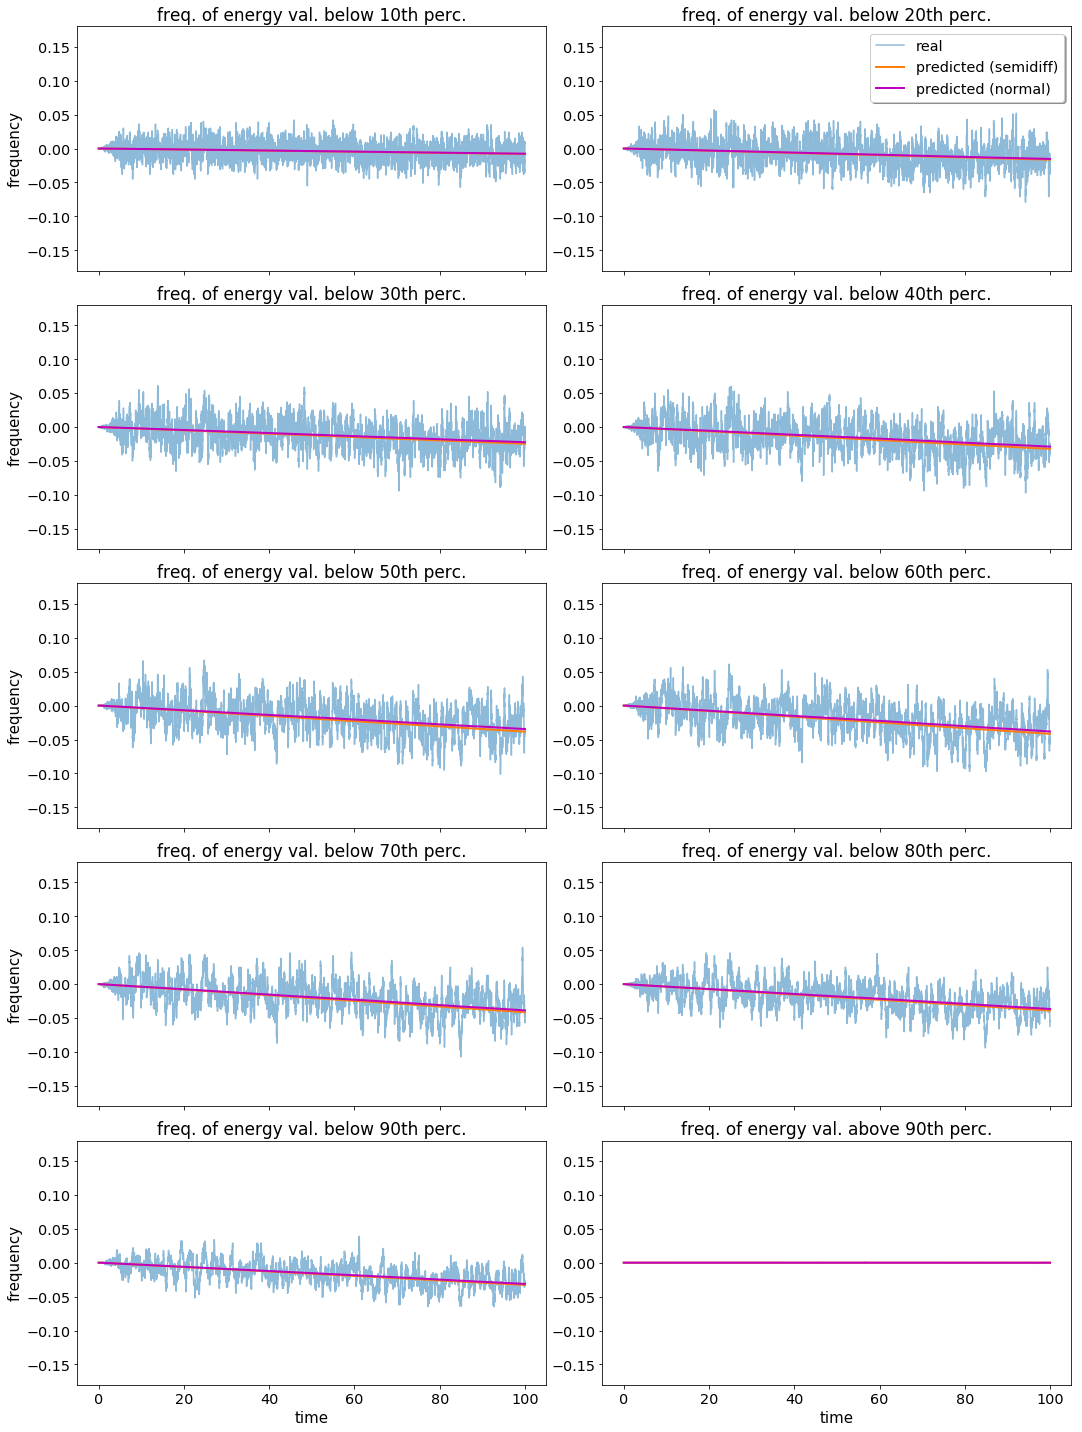

In [10]:
fig, ax = plt.subplots(5, 2, sharex='all', sharey=False, figsize=(15, 20))

titles = [
    f'freq. of {observable} val. below 10th perc.',
    f'freq. of {observable} val. below 20th perc.',
    f'freq. of {observable} val. below 30th perc.',
    f'freq. of {observable} val. below 40th perc.',
    f'freq. of {observable} val. below 50th perc.',
    f'freq. of {observable} val. below 60th perc.',
    f'freq. of {observable} val. below 70th perc.',
    f'freq. of {observable} val. below 80th perc.',
    f'freq. of {observable} val. below 90th perc.',
    f'freq. of {observable} val. above 90th perc.',
]

k = 0
for i in range(5):
    for j in range(2):
        l1, = ax[i, j].plot(np.arange(0, 100, 0.01), resp_real[obs_all[k]].values, alpha=0.5)
        l2, = ax[i, j].plot(np.arange(0, 100, 0.01), resp_pred_semidiff[obs_all[k]][0:10000], linewidth=2)
        l3, = ax[i, j].plot(np.arange(0, 100, 0.01), resp_pred_normal[obs_all[k]][0:10000], linewidth=2, color='m')
        ax[i, j].set_title(titles[k], size=17)
        ax[i, j].set_ylim([-0.18, 0.18])
        ax[i, j].tick_params(labelsize='x-large')
        std_real = resp_real[obs_all[k]].std().values
        avg_real = resp_real[obs_all[k]].mean().values
        sig_digit_real = -math.floor(math.log10(std_real))
        std_pred_normal = resp_pred_normal[obs_all[k]][0:10000].std()
        avg_pred_normal = resp_pred_normal[obs_all[k]][0:10000].mean()
        sig_digit_pred_normal = -math.floor(math.log10(std_pred_normal))
        std_pred_semidiff = resp_pred_semidiff[obs_all[k]][0:10000].std()
        avg_pred_semidiff = resp_pred_semidiff[obs_all[k]][0:10000].mean()
        sig_digit_pred_semidiff = -math.floor(math.log10(std_pred_semidiff))

        if k==1:
            ax[i, j].legend((l1, l2, l3), ('real', 'predicted (semidiff)', 'predicted (normal)'), loc='upper right', shadow=True, fontsize='x-large')
        if not j%2:
            ax[i, j].set_ylabel('frequency', size=15)
        if i==4:
            ax[i, j].set_xlabel('time', size=15)
            
        k += 1

plt.tight_layout()

## Single Plot

In [11]:
force_linear_coefficient = 0.01
deactivation_time = 100
forcing = f'LF_8.0_{force_linear_coefficient}_0_{deactivation_time}'
observable = 'energy'
obs = f'{observable}_exceed_0.99q'

In [12]:
response_p1 = xr.open_dataarray(os.path.join(REF_RESP_PATH[0], observable, f'response_lorenz96_rk4_{obs}_SF_8.0_1.0_0.nc'))
response_m1 = xr.open_dataarray(os.path.join(REF_RESP_PATH[1], observable, f'response_lorenz96_rk4_{obs}_SF_8.0_-1.0_0.nc'))
response_semidiff = (response_p1 - response_m1)/2
chi_semidiff = analysis.compute_susceptibility(response_semidiff.values.squeeze())
chi_normal = analysis.compute_susceptibility(response_p1.values.squeeze())

resp_real = xr.open_dataarray(
    f'/home/marco/phd/data/response/lorenz96/rk4/{forcing}/{observable}/response_lorenz96_rk4_{obs}_{forcing}.nc'
)
resp_pred_semidiff = analysis.compute_response(chi_semidiff, forcings.LinearForcing(
    linear_coefficient=force_linear_coefficient,
    deactivation_time=deactivation_time
))
resp_pred_normal = analysis.compute_response(chi_normal , forcings.LinearForcing(
    linear_coefficient=force_linear_coefficient,
    deactivation_time = deactivation_time
))

### Plot

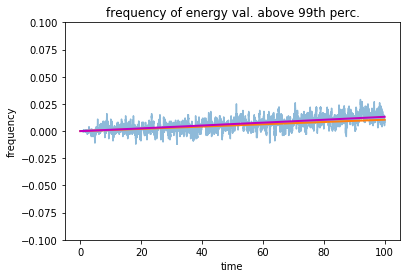

In [13]:
l1, = plt.plot(np.arange(0, 100, 0.01), resp_real.values, alpha=0.5)
l2, = plt.plot(np.arange(0, 100, 0.01), resp_pred_semidiff[0:10000], linewidth=2)
l3, = plt.plot(np.arange(0, 100, 0.01), resp_pred_normal[0:10000], linewidth=2, color='m')
#plt.set_title(titles[k], size=17)
plt.ylim(-0.10, 0.10)
#plt.tick_params(labelsize='x-normal')
std_real = resp_real.std().values
avg_real = resp_real.mean().values
sig_digit_real = -math.floor(math.log10(std_real))
std_pred_normal = resp_pred_normal[0:10000].std()
avg_pred_normal = resp_pred_normal[0:10000].mean()
sig_digit_pred_normal = -math.floor(math.log10(std_pred_normal))
std_pred_semidiff = resp_pred_semidiff[0:10000].std()
avg_pred_semidiff = resp_pred_semidiff[0:10000].mean()
sig_digit_pred_semidiff = -math.floor(math.log10(std_pred_semidiff))
#plt.legend((l1, l2, l3), ('real', 'predicted (semidiff)', 'predicted (normal)'), loc='lower right', shadow=True)
plt.title('frequency of energy val. above 99th perc.')
plt.ylabel('frequency')
plt.xlabel('time')

if SAVE_FIG:
    plt.savefig('/home/marco/phd/devel/phd/logbook/fig/pred_{}_L_{}_{}.png'.format(
        obs.replace('.', ''), str(force_linear_coefficient).replace('.', ''), str(deactivation_time)
    ))

### Plot cumulative distribution approximation

In [14]:
observable = 'energy'
QUANTILES_PATH = f'/home/marco/phd/data/obs/lorenz96/rk4/CF_8.0/quantiles/obs_lorenz96_rk4_CF_8.0_quantiles_{observable}.nc'

quantiles_value [7.53776544e-13 1.45182113e-03 5.83259957e-03 1.31108615e-02
 2.32754754e-02 3.63813875e-02 5.25030234e-02 7.14871202e-02
 9.34102866e-02 1.18262637e-01 1.46248285e-01 1.77028105e-01
 2.11034387e-01 2.47964341e-01 2.88183520e-01 3.31504484e-01
 3.77903209e-01 4.27648037e-01 4.80880458e-01 5.36891824e-01
 5.96644390e-01 6.59970027e-01 7.26726950e-01 7.97100040e-01
 8.71174843e-01 9.48642522e-01 1.03027263e+00 1.11572169e+00
 1.20526696e+00 1.29766099e+00 1.39477229e+00 1.49639540e+00
 1.60210717e+00 1.71206101e+00 1.82671952e+00 1.94519070e+00
 2.06937697e+00 2.19832069e+00 2.33189602e+00 2.47035881e+00
 2.61396680e+00 2.76288319e+00 2.91776276e+00 3.07858320e+00
 3.24421716e+00 3.41554679e+00 3.59456683e+00 3.78065115e+00
 3.97238482e+00 4.17061878e+00 4.37677145e+00 4.58980678e+00
 4.81048130e+00 5.04067225e+00 5.27816401e+00 5.52368641e+00
 5.77879906e+00 6.04298837e+00 6.31669044e+00 6.60037366e+00
 6.89431581e+00 7.19890608e+00 7.51689972e+00 7.84926674e+00
 8.19382

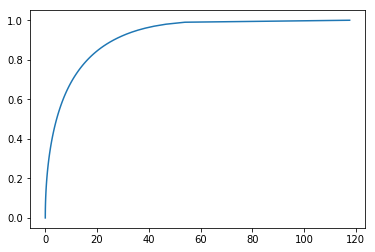

In [16]:
quantiles = xr.open_dataarray(QUANTILES_PATH)
x = quantiles.values
y = quantiles.quantile_order
print('quantiles_value', x)
print('quantiles_order', y)
plt.plot(x, y)

In [ ]:
force_linear_coefficient = 0.02
deactivation_time = 100
forcing = f'LF_8.0_{force_linear_coefficient}_0_{deactivation_time}'

In [ ]:
obs_all = [f"{observable}_below_{format(np.round(quant, 2), '.2f')}q" for quant in np.arange(0, 1.001, 0.01)]
chi_normal = {}
for obs in obs_all:
    response_p1 = xr.open_dataarray(os.path.join(
        REF_RESP_PATH[0],
        observable,
        f'response_lorenz96_rk4_{obs}_SF_8.0_1.0_0.nc'
    ))
    chi_normal[obs] = analysis.compute_susceptibility(response_p1.values.squeeze())
resp_pred_normal = {}
for obs in obs_all:
    resp_pred_normal[obs] = analysis.compute_response(chi_normal[obs], forcings.LinearForcing(
        linear_coefficient=force_linear_coefficient,
        deactivation_time = deactivation_time
    ))

In [ ]:
resp_pred_normal_t50 = [resp_pred_normal[obs][5000] for obs in obs_all]
y_pred_t50 = y + resp_pred_normal_t50
resp_pred_normal_t100 = [resp_pred_normal[obs][9999] for obs in obs_all]
y_pred_t100 = y + resp_pred_normal_t100

#### Plot CDF

In [ ]:
plt.plot(x, y, label='unperturbed')
plt.plot(x, y_pred_t50, label='pert. t=50')
plt.plot(x, y_pred_t100, label='pert. t=100')
plt.title('Predicted CDF evolution')
plt.legend()

if SAVE_FIG:
    plt.savefig('../logbook/fig/pred_cdf_{}_L_{}_{}.png'.format(
        obs.replace('.', ''), str(force_linear_coefficient).replace('.', ''), str(deactivation_time)
    ))

#### Plot PDF

In [ ]:
x_pdf_orig = np.diff(x)/2 + x[:-1]
y_pdf_orig = np.diff(y)/np.diff(x)
y_pdf_t_100 = np.diff(y + resp_pred_normal_t100)/np.diff(x)
y_pdf_t_50 = np.diff(y + resp_pred_normal_t50)/np.diff(x)

In [ ]:
plt.plot(x_pdf_orig, y_pdf_orig, label='unperturbed')
plt.plot(x_pdf_orig, y_pdf_t_50, label='pert. t=50')
plt.plot(x_pdf_orig, y_pdf_t_100, label='pert. t=100')
plt.title('Predicted PDF evolution')
plt.legend()

if SAVE_FIG:
    plt.savefig('../logbook/fig/pred_pdf_{}_L_{}_{}.png'.format(
        obs.replace('.', ''), str(force_linear_coefficient).replace('.', ''), str(deactivation_time)
    ))

A zoom

In [ ]:
plt.plot(x_pdf_orig, y_pdf_orig, label='unperturbed')
plt.plot(x_pdf_orig, y_pdf_t_50, label='pert. t=50')
plt.plot(x_pdf_orig, y_pdf_t_100, label='pert. t=100')
plt.legend()
plt.xlim(0,0.02)

if SAVE_FIG:
    plt.savefig('../logbook/fig/pred_pdf_zoom_{}_L_{}_{}.png'.format(
        obs.replace('.', ''), str(force_linear_coefficient).replace('.', ''), str(deactivation_time)
    ))